In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
import time
from tqdm import tqdm
import datetime as dt
from collections import Counter

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 10)

# text processing
import re
with open('stopwords-de.json', 'r') as file:
    stopwords_de = json.load(file)
from  nltk.stem.snowball import SnowballStemmer

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# feature processing
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

# sklearn feature extraction
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# cluster algorithms
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover
from processing_visualizations import silhouette_plot, elbow_plot, threed_plot, threed_subplots, twod_plot, tsne_plot

# Loading data from json and creating DataFrame

In [4]:
read_in = True
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,5)]

if read_in:
    parties = parties
    dates = dates
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')

  0%|          | 0/3 [00:00<?, ?it/s]

Loading: ['08-02', '08-03', '08-04']


TypeError: __new__() got an unexpected keyword argument 'inplace'

# Create one dataframe containing all data without duplicates
Having separate dataframes for each party only makes limited sense: many parties are mentioned more than once, thus there are many duplicates in the data. Whether only one party is mentioned in a given tweet can be deduced from the subsequently created columns 'tags', 'mentions', and 'parties'.

### Extract hashtags and party mentions, deduplication
Create columns 'tags', 'clean_text', 'mentions', and 'parties' (df_processing)

- tags: hashtags found in the full tweet
- parties: parties mentioned without hashtag
- clean_text: hashtags, RT, and special characters removed from full_text
- deduplicate data by dropping rows with duplicates in the clean text -> approx. halves the data
- create column 'user_id' and drop further user information
- save data frame as pickle

In [24]:
collapse = True
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

dumping data to pickle
data dumped


# 1. New clustering: using what I've learned from old trials and stemmed vocab
1. create partial dataframe containing only relevant columns: tags, clean_text, mentions, parties
2. tags, parties, mentions are lists in a df cell - make them non-lists by joining them in the cell using commas
3. create pipelines to prepare features individually (could be done without pipelines here, but this way feature preparation is more easily expandable and I find it more readable)
4. map the individual pipelines to the respective features (columns in a dataframe) and unite the features
5. create full pipelines: clustering, elbow visualization, and decomposition for final visualization
6. use elbow visualizer and silhouette score to define number of clusters
7. fit-predict clusters using MiniBatchKmeans, DBSCAN
8. reduce dimensionality to 2 or 3 dimensions using truncatedSVD or use tSNE and visualize

In [25]:
df_part = all_data.iloc[:, [2, 3, 4, 5, 6, 7]].copy()

'''
In the df, parties, mentions, tags are stored as lists. To make the data in these lists available to the algorithm, they are extracted 
using .join. They are then seen as individual elements. 
The party remover removes the parties from the clean text.
'''

df_part.loc[:, 'tags'] = df_part.loc[:, 'tags'].apply(", ".join)
df_part.loc[:, 'parties'] = df_part.loc[:, 'parties'].apply(", ".join)
df_part.loc[:, 'mentions'] = df_part.loc[:, 'mentions'].apply(', '.join)

### 1.0 Clustering of clean text

In [26]:
clean_text = df_part.loc[:, 'clean_text']

In [104]:
tfidf_ct = TfidfVectorizer(ngram_range=(1, 2),
                        stop_words=stopwords_de,
                        min_df=0.005,
                        dtype=float)

X_ct = tfidf_ct.fit_transform(clean_text)

print(X_ct.shape)

(46106, 187)


In [118]:
km_pars = {'max_no_improvement':100, 
           'batch_size' : 100,
           'n_init' : 10, 
           'init':'random',
           'random_state':123,
           'max_iter':200}
kmeans_ct = MiniBatchKMeans(n_clusters=90, 
                            **km_pars)

y_km_ct = kmeans_ct.fit_predict(X_ct)

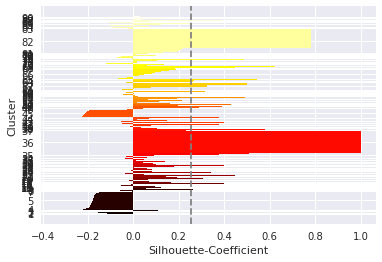

In [119]:
silhouette_plot(X_ct[:5000], y_km_ct[:5000]) # I know, the y-axis is not nice! Yet.

2
3
4
5
10
20
50
75
100
150


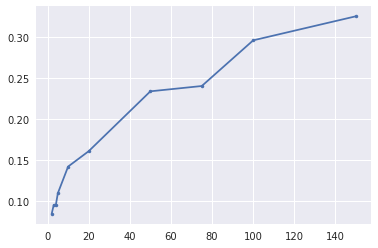

In [107]:
#x-axis: mean silhouette coefficient per k
#y-axis: k

elbow_plot(X_ct[:5000], MiniBatchKMeans, [2,3,4,5,10,20,50, 75, 100, 150], **km_pars)

[ 0.05605474  0.0368131 ]


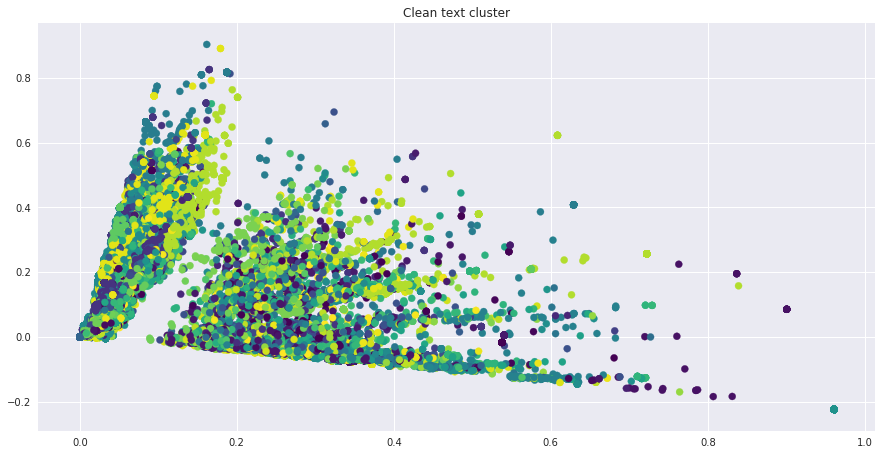

In [108]:
twod_plot(X_ct, y_km_ct, title='Clean text cluster')

[ 0.0560549   0.03681178  0.03859317]


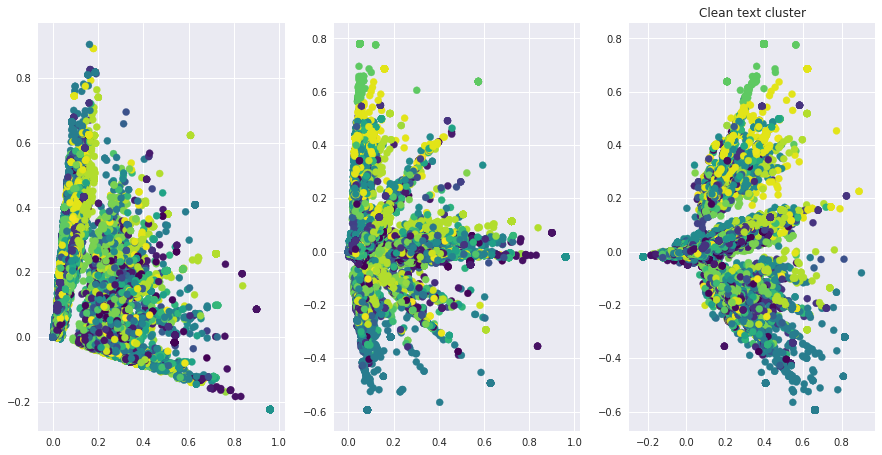

In [109]:
threed_subplots(X_ct, y_km_ct, title='Clean text cluster')

[ 0.05605475  0.03681256  0.03859322]


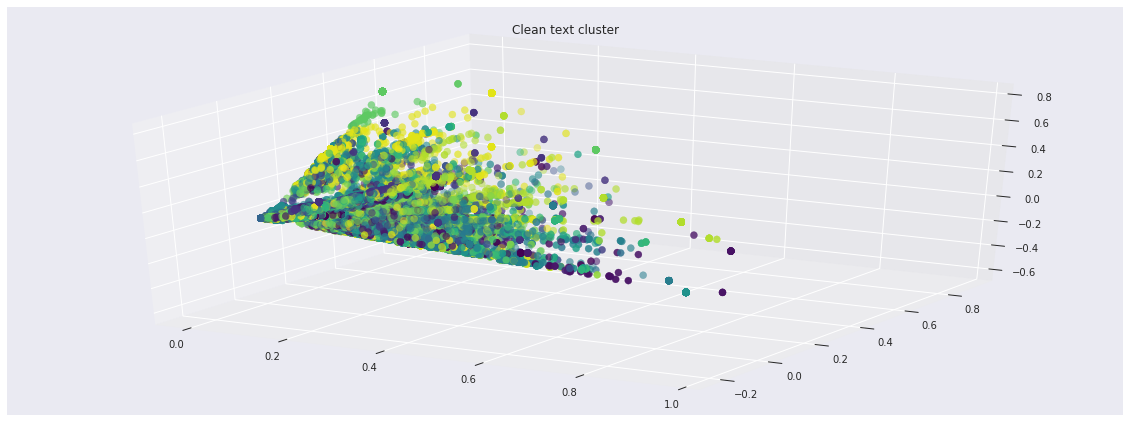

In [110]:
threed_plot(X_ct, y_km_ct, title='Clean text cluster')

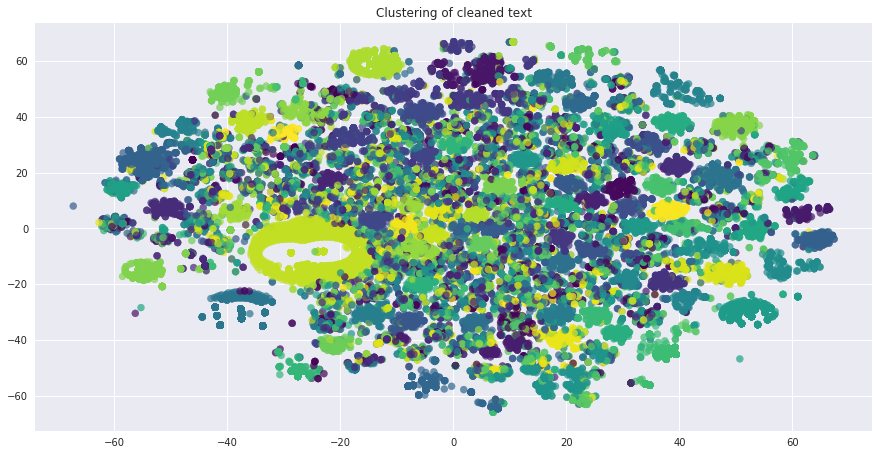

In [123]:
save_model_ct = False
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_ct:
    tsne_model_ct = TSNE().fit_transform(X_ct.toarray())
    filename = '../Models/'+date+'-tsne_ct.pkl' 
    print(filename)
    with open(filename, 'wb') as file:  
        pickle.dump(tsne_model_ct, file)
else:
    file = '../Models/2018_08_29_08_59-tsne_ct.pkl'
    with open(file, 'rb') as f:  
        tsne_model_ct = pickle.load(f)

tsne_plot(tsne_model_ct, no_samples=None, y=y_km_ct, title='Clustering of cleaned text', savefig=False)

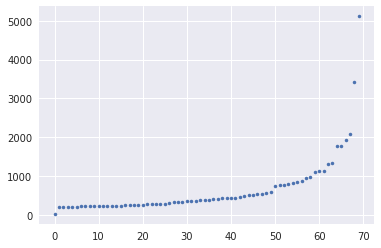

In [111]:
# number of values per cluster: follows 20:80 rule
plt.plot(sorted(Counter(kmeans_ct.labels_).values()), '.')

In [112]:
labels_ct = kmeans_ct.labels_

C_ct = Counter(labels_ct)
print(sorted(C_ct.items(), key=lambda x: x[1]))

[(3, 29), (6, 207), (12, 207), (14, 209), (57, 212), (56, 215), (39, 221), (19, 222), (32, 224), (64, 228), (25, 228), (59, 232), (50, 238), (69, 239), (9, 239), (37, 241), (13, 248), (24, 251), (21, 254), (51, 257), (11, 257), (60, 275), (16, 276), (38, 281), (43, 285), (63, 294), (8, 303), (20, 325), (68, 334), (23, 345), (48, 356), (7, 357), (49, 360), (53, 376), (36, 378), (58, 398), (26, 417), (34, 420), (1, 426), (18, 440), (42, 446), (44, 448), (65, 471), (28, 483), (67, 517), (41, 523), (27, 537), (2, 550), (47, 569), (62, 585), (17, 749), (45, 767), (15, 771), (55, 800), (46, 832), (40, 838), (33, 869), (52, 943), (0, 977), (5, 1097), (30, 1126), (31, 1141), (66, 1320), (10, 1328), (61, 1776), (29, 1787), (4, 1920), (35, 2078), (54, 3437), (22, 5117)]


In [113]:
# Extract the top terms per cluster

order_centroids = kmeans_ct.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_ct.get_feature_names()
clusters_ct= {}

for i in range(70):
    clusters_ct[i] = []
    for ind in order_centroids[i, :10]:
        if i not in clusters_ct:
            clusters_ct[i].append('{}'.format(terms[ind]))
        clusters_ct[i].append('{}'.format(terms[ind]))

text_cluster = pd.DataFrame.from_dict(clusters_ct)
text_cluster.to_csv('../Data/text_cluster.csv')

In [114]:
text_cluster

0         1           2          3           4     ...      \
0           csu  parteien     einfach        afd         afd    ...       
1          fuer       afd         afd       fuer       waere    ...       
2        soeder       spd     koennen        spd      wuerde    ...       
3           afd     linke         spd    koennen     politik    ...       
4           cdu      fuer       linke    glauben        fuer    ...       
5         finde    linken        fuer      sagen        klar    ...       
6         union     ueber      lassen     arbeit          17    ...       
7       politik   politik     politik  regierung     steinke    ...       
8  fluechtlinge      klar  eigentlich       nazi        nazi    ...       
9        wuerde    partei      gruene     lassen  natuerlich    ...       

             65           66      67       68         69  
0  stauffenberg        linke     via  koennte  bundestag  
1        hitler         fuer     afd      afd        afd  
2     verraeter       linken     spd      spd     partei  
3           afd          spd  gruene     fuer       fuer  
4       steinke  wagenknecht    fuer    waere        cdu  
5        jugend      politik   ueber    linke      linke  
6          chef     bewegung   linke      cdu        spd  
7           via        links   union   gruene     gruene  
8     politiker       gruene     cdu  gruenen  deutschen  
9     deutschen   eigentlich  merkel   partei   parteien  

[10 rows x 70 columns]

In [115]:
df_part['labels'] = labels_ct

df_part[df_part['labels'] == 53].head() # (53, 7266)

tags  \
created_at                                              
2018-08-02 02:21:00                          AfD, AfD   
2018-08-02 04:01:42                     LTWBayern2018   
2018-08-02 05:58:35  AfD, Niedersachsen, Nazis, ltnds   
2018-08-02 06:00:02  AfD, Niedersachsen, Nazis, ltnds   
2018-08-02 06:49:49                               AfD   

                                                                                             mentions  \
created_at                                                                                              
2018-08-02 02:21:00  AgenturaContra, RolfMll35367465, bimbas_world, Sam55385029, AFDHessen, Weltwoche   
2018-08-02 04:01:42                                                               SaschaUlbrich, welt   
2018-08-02 05:58:35                                                                                     
2018-08-02 06:00:02                                                                        GruenMeyer   
2018-08-02 06:49:49                                                                            faznet   

                                                                                                                                                                                                                  clean_text  \
created_at                                                                                                                                                                                                                     
2018-08-02 02:21:00        Die   AfD  sieht  in  der  Politik  nicht  so  extrem  eine  Staatsreligion  wie  Altparteien  und  sind  nicht  so  extrem  in  dieser  Form  vom  Glauben   Da  ist  die   AfD  freier  aber...   
2018-08-02 04:01:42                                                            Das  erste  Ankerzentrum  schliesst  schon  wieder  2019  via       Quasi  PUeNKTLICH   gt  NACH  lt   DER   LTWBayern2018     Daran  sieht     
2018-08-02 05:58:35                                                                 Und  die   AfD   Niedersachsen  sieht  wieder  keinen  Anlass  zum  Handeln  wenn  Mitglieder  wie   Nazis  schreiben    ltnds  einLink    
2018-08-02 06:00:02                                                                 Und  die   AfD   Niedersachsen  sieht  wieder  keinen  Anlass  zum  Handeln  wenn  Mitglieder  wie   Nazis  schreiben    ltnds  einLink    
2018-08-02 06:49:49                                                  Mitten  in  einer  der  reichsten  Kommunen  spricht  die  hessische   AfD  ueber  ihre  Aengste    und  sieht  diese  schon  deshalb  begruendet   w     

                    parties  \
created_at                    
2018-08-02 02:21:00     AfD   
2018-08-02 04:01:42           
2018-08-02 05:58:35     AfD   
2018-08-02 06:00:02     AfD   
2018-08-02 06:49:49     AfD   

                                                                                                                                                                                                                     stemmed  \
created_at                                                                                                                                                                                                                     
2018-08-02 02:21:00        die   afd  sieht  in  der  polit  nicht  so  extr  ein  staatsreligion  wie  altpartei  und  sind  nicht  so  extr  in  dies  form  vom  glaub   da  ist  die   afd  freier  aber  dennoch  gu...   
2018-08-02 04:01:42                                                               das  erst  ankerzentrum  schliesst  schon  wied  2019  via       quasi  puenktlich   gt  nach  lt   der   ltwbayern2018     daran  sieht     
2018-08-02 05:58:35                                                                           und  die   afd   niedersachs  sieht  wied  kein  anlass  zum  handeln  wenn  mitglied  wie   nazis  schreib    ltnds  einlink    
2018-0

In [80]:
df_part[df_part['labels'] == 6].head() # (6, 3108)

tags                 mentions  \
created_at                                                       
2018-08-02 00:03:28           nonazis                 ozan_559   
2018-08-02 00:06:31               AfD  DJanecek, ChristianBlex   
2018-08-02 00:06:43  AfD, altparteien                            
2018-08-02 00:07:38                                              
2018-08-02 00:08:35                               YungHurnsohn   

                                                                                                                                                                                                                  clean_text  \
created_at                                                                                                                                                                                                                     
2018-08-02 00:03:28                                                                                                                               Heisst  das  du  hast  die  AFD  gewaehlt       ich  wusste  es   nonazis    
2018-08-02 00:06:31                                                                     Ihr  Heimatzerstoerer  von  der   AfD  solltet  lieber  mal  die  Fuesse  still  halten   Nicht   dass  eure  Kleine  Anfrage  vom     
2018-08-02 00:06:43  Hr   Knoop  nicht  nur  als  VP  wird  die   AfD  in  Zukunft  bestehen  Nein   auch  als  Regierungspartei  mit  einer  absoluten  Mehrheit  DE  gibt  sich  nicht  einfach  auf  amp  laesst  die ...   
2018-08-02 00:07:38   Absolut  richtig       Bei  der  AfD  wird  sich  einer  rausgepickt   Das  aber  die  GESAMTE  GROKO     in  den  Abgrund  treibt  und  die  Mullahs  hofiert   das  ist  Salonfaehig        einLink    
2018-08-02 00:08:35                                                         Retweetet  diesen  Tweet  fuer     10  grad  kaelter   Aufloesung  der  AFD   Dieter  bohlen   30  jahre  lebenszeit   Essen   Liebe   Schoenh     

                    parties  \
created_at                    
2018-08-02 00:03:28     AfD   
2018-08-02 00:06:31     AfD   
2018-08-02 00:06:43     AfD   
2018-08-02 00:07:38     AfD   
2018-08-02 00:08:35     AfD   

                                                                                                                                                                                                                     stemmed  \
created_at                                                                                                                                                                                                                     
2018-08-02 00:03:28                                                                                                                                heisst  das  du  hast  die  afd  gewaehlt       ich  wusst  es   nonazis    
2018-08-02 00:06:31                                                                                 ihr  heimatzersto  von  der   afd  solltet  lieb  mal  die  fuess  still  halt   nicht   dass  eur  klein  anfrag  vom     
2018-08-02 00:06:43  hr   knoop  nicht  nur  als  vp  wird  die   afd  in  zukunft  besteh  nein   auch  als  regierungspartei  mit  ein  absolut  mehrheit  de  gibt  sich  nicht  einfach  auf  amp  laesst  die   altp...   
2018-08-02 00:07:38         absolut  richtig       bei  der  afd  wird  sich  ein  rausgepickt   das  aber  die  gesamt  groko     in  den  abgrund  treibt  und  die  mullah  hofiert   das  ist  salonfaeh        einlink    
2018-08-02 00:08:35                                                                        retweetet  dies  tweet  fuer     10  grad  kaelt   aufloes  der  afd   diet  bohl   30  jahr  lebenszeit   ess   lieb   schoenh     

                                user_id  labels  
created_at                                       
2018-08-02 00:03:28  779052504227127300       6  
2018-08-02 00:06:31  943442071377113088       6  
2018-08-02 00:

In [81]:
df_part[df_part['labels'] == 56].head() # (56, 1608)

tags  \
created_at                                                                                       
2018-08-02 00:03:07                                                                    Dresden   
2018-08-02 00:13:21                                                                        AfD   
2018-08-02 00:27:17                                                                              
2018-08-02 00:49:03  SimonDennenmoser, DietmarDominikHennig, MichaelWeller, AfDGoeppingen, afd   
2018-08-02 00:58:24                                                                              

                                            mentions  \
created_at                                             
2018-08-02 00:03:07                              AfD   
2018-08-02 00:13:21  AfDimBundestag, PeterBoehringer   
2018-08-02 00:27:17                    Joerg_Meuthen   
2018-08-02 00:49:03                  JungeAlternativ   
2018-08-02 00:58:24                         manomama   

                                                                                                                                                                            clean_text  \
created_at                                                                                                                                                                               
2018-08-02 00:03:07        Grausamer  Mord  an  2  kleinen  Maedchen  erschuettert   Dresden     Was  fuer  ein  unfassbar  krankes  Verbrechen   Zwei  Geschwister   3   amp   6  J     
2018-08-02 00:13:21                                              Wir  lehnen  als   AfD  Rettungszahlungen  fuer     von  40  55  Mrd   Euro  ab        Vorsitzender  des  Haushalts     
2018-08-02 00:27:17                          Eine  offene  Kampfansage  an  den  Rechtsstaat      Was  das  fuer  unser  Vaterland  bedeutet   kann  sich  jeder  ausmalen   der  no     
2018-08-02 00:49:03                              Wir  stehen  ein  fuer  unsere  Ueberzeugungen     SimonDennenmoser   DietmarDominikHennig   MichaelWeller   AfDGoeppingen   afd  h     
2018-08-02 00:58:24                Keine  Hilfe  fuer  Alleinerziehende   die  sich  ohne  Not  vom  Partner  trennen     Wer  das   was  die  Afd  im  Programm  hat   wirklich  wi     

                    parties  \
created_at                    
2018-08-02 00:03:07     AfD   
2018-08-02 00:13:21     AfD   
2018-08-02 00:27:17           
2018-08-02 00:49:03     AfD   
2018-08-02 00:58:24     AfD   

                                                                                                                                                                 stemmed  \
created_at                                                                                                                                                                 
2018-08-02 00:03:07        grausam  mord  an  2  klein  maedch  erschuettert   dresd     was  fuer  ein  unfassbar  krank  verbrech   zwei  geschwist   3   amp   6  j     
2018-08-02 00:13:21                                             wir  lehn  als   afd  rettungszahl  fuer     von  40  55  mrd   euro  ab        vorsitz  des  haushalt     
2018-08-02 00:27:17                       ein  off  kampfansag  an  den  rechtsstaat      was  das  fuer  uns  vaterland  bedeutet   kann  sich  jed  ausmal   der  no     
2018-08-02 00:49:03                                  wir  steh  ein  fuer  uns  ueberzeug     simondennenmos   dietmardominikhenn   michaelwell   afdgoepping   afd  h     
2018-08-02 00:58:24             kein  hilf  fuer  alleinerzieh   die  sich  ohn  not  vom  partn  trenn     wer  das   was  die  afd  im  programm  hat   wirklich  wi     

                                 user_id  labels  
created_at                                        
2018-08-02 00:03:07  1013834405884907521      56  
2018-08-02 00:13:21  1017155744016158720      56  
2018-08-02 00:27:17           3127709360      56  
2018-08-02 00:49:03   9626139

In [82]:
df_part[df_part['labels'] == 60].head() # (60, 122)

tags              mentions  \
created_at                                                               
2018-08-02 04:30:09                                         mampel2000   
2018-08-02 04:57:53                                                      
2018-08-02 07:58:25                                           DFB_Team   
2018-08-02 08:36:37        ThePressIsNotTheEnemy                         
2018-08-02 08:56:41  Verfassungsschutz, NSU, afd  nwnews, cem_oezdemir   

                                                                                                                                                                                                                  clean_text  \
created_at                                                                                                                                                                                                                     
2018-08-02 04:30:09   Das  ist  die  Folge  dessen   dass  die  AfD  und  Medien  das  Thema  Migration  zum  Ueberthema  deklarieren   Entgegensteuern  und  die  wirklich  pressierenden  Dinge  ansprechen   Genau  da...   
2018-08-02 04:57:53                                                                                            Und  die  AfD  erzaehlt  auf  allen  TV  Kanaelen   dass  sie  von  den  Medien  boykottiert  wird   einLink    
2018-08-02 07:58:25             So  noch  keine  Erklaerungen  von  Herrn  Grindel   Bierhoff  und  Loew  ueber  die  AFD  fans  Medien  Attacken  gegen  Oezil   Es  ist  denn  ganz  normal   Und  kein   Danke   Mesut      
2018-08-02 08:36:37                                   Ein  Vorgeschmack   was  uns  erwartet   wenn  wir  der  AfD  und  SVP  weiter  zuschauen  wie  sie  unsere  Medien  diskreditieren    ThePressIsNotTheEnemy  einLink    
2018-08-02 08:56:41    Genau     So  wie  vom   Verfassungsschutz  und  der   NSU  und  freigelassenen    Terroristen  die  als  Ausnahmeerscheinung  in  den  Medien  genannt  werden  und  von  der   afd  hofiert  sin...   

                    parties  \
created_at                    
2018-08-02 04:30:09     AfD   
2018-08-02 04:57:53     AfD   
2018-08-02 07:58:25     AfD   
2018-08-02 08:36:37     AfD   
2018-08-02 08:56:41     AfD   

                                                                                                                                                                                                                     stemmed  \
created_at                                                                                                                                                                                                                     
2018-08-02 04:30:09   das  ist  die  folg  dess   dass  die  afd  und  medi  das  thema  migration  zum  ueberthema  deklari   entgegensteu  und  die  wirklich  pressier  ding  ansprech   genau  das  ist  zur  zeit  e...   
2018-08-02 04:57:53                                                                                                  und  die  afd  erzaehlt  auf  all  tv  kanael   dass  sie  von  den  medi  boykottiert  wird   einlink    
2018-08-02 07:58:25                             so  noch  kein  erklaer  von  herrn  grindel   bierhoff  und  loew  ueb  die  afd  fan  medi  attack  geg  oezil   es  ist  denn  ganz  normal   und  kein   dank   mesut      
2018-08-02 08:36:37                                                ein  vorgeschmack   was  uns  erwartet   wenn  wir  der  afd  und  svp  weit  zuschau  wie  sie  uns  medi  diskrediti    thepressisnottheenemy  einlink    
2018-08-02 08:56:41    genau     so  wie  vom   verfassungsschutz  und  der   nsu  und  freigelass    terrorist  die  als  ausnahmeerschein  in  den  medi  genannt  werd  und  von  der   afd  hofiert  sind   sowas  me...   

                                user_id  labels  
created_at                                       
2018-08-02 04:30:09  712637855672242176      60  
2018-08-02 04:57:53

In [84]:
df_part[df_part['labels'] == 36].head() # (36, 193)

tags             mentions  \
created_at                                                                 
2018-08-02 03:31:12  Robinson, AfD, SPD, Terror, De          66Freedom66   
2018-08-02 05:16:33                                         JahnLamberty   
2018-08-02 07:45:49          RT, Spanien, Migranten  EchoPRN, AfD_Bayern   
2018-08-02 08:54:21                                         JahnLamberty   
2018-08-02 09:03:23                                         Anke52936620   

                                                                                                                                                                                                                  clean_text  \
created_at                                                                                                                                                                                                                     
2018-08-02 03:31:12                                                          OMG    was  haben  die  mit  ihnen  Gemacht    Tommy   Robinson  nach  Freilassung  nur  noch  Haut  und  Knochen     AfD   SPD   Terror   De     
2018-08-02 05:16:33                                                         ein  wie  ich  finde   interessantes  Interview  mit  Hr   Sarrazin  gt  Zitat  daraus     Angela  Merkel  ist  fuer  mich  der  Inbegriff  de     
2018-08-02 07:45:49         Werden  wir  auch  mal  eine  Headline   Risse  in     Willkommenskultur   lesen   Wahrscheinlich  erst  wenn  es  zu  spaet  ist    Spanien  erkennt   dass  sie  nicht  Millionen  von  Afr...   
2018-08-02 08:54:21     dieser  Kommentar  ist  sehr  ignorant   Na  klar  diese  seltsame  Art  des  Linkentumes   welches  sich  in  den  BT  in  Berlin  und  LT  s  in  de  etabliert  hat   gefaellt  mir  gar  nich...   
2018-08-02 09:03:23   nein   die  adressierung  an  verhaltensgestoerte  panikdeformierte  re  afd  bande  ist  korrekt    diesmal  lassen  wir  uns  nicht  von  einem  getarnten  faschisten  vogelschiss  spinnerkluen...   

                        parties  \
created_at                        
2018-08-02 03:31:12    AfD, SPD   
2018-08-02 05:16:33               
2018-08-02 07:45:49         AfD   
2018-08-02 08:54:21  AfD, LINKE   
2018-08-02 09:03:23         AfD   

                                                                                                                                                                                                                     stemmed  \
created_at                                                                                                                                                                                                                     
2018-08-02 03:31:12                                                                   omg    was  hab  die  mit  ihn  gemacht    tommy   robinson  nach  freilass  nur  noch  haut  und  knoch     afd   spd   terror   de     
2018-08-02 05:16:33                                                            ein  wie  ich  find   interessant  interview  mit  hr   sarrazin  gt  zitat  daraus     angela  merkel  ist  fuer  mich  der  inbegriff  de     
2018-08-02 07:45:49         werd  wir  auch  mal  ein  headlin   riss  in     willkommenskultur   les   wahrschein  erst  wenn  es  zu  spaet  ist    spani  erkennt   dass  sie  nicht  million  von  afrikan    migrant...   
2018-08-02 08:54:21     dies  kommentar  ist  sehr  ignorant   na  klar  dies  seltsam  art  des  linkentum   welch  sich  in  den  bt  in  berlin  und  lt  s  in  de  etabliert  hat   gefaellt  mir  gar  nicht   doch...   
2018-08-02 09:03:23   nein   die  adressier  an  verhaltensgestoert  panikdeformiert  re  afd  band  ist  korrekt    diesmal  lass  wir  uns  nicht  von  ein  getarnt  faschist  vogelschiss  spinnerkluengel   lt  gaul...   

                                 user_id  labels  
created_at                                        
2018-08-02 03:31:12   950248

In [86]:
df_part[df_part['labels'] == 14].head() # (14, 200)

tags  \
created_at                                          
2018-08-02 04:44:38  Essen, Ausländerbehörde, AfD   
2018-08-02 06:18:40                          Jung   
2018-08-02 06:40:14                                 
2018-08-02 06:44:54                                 
2018-08-02 06:54:16                                 

                                                                            mentions  \
created_at                                                                             
2018-08-02 04:44:38                                                 salegen, zac1967   
2018-08-02 06:18:40                                       AfDKompakt, AfD_FraktionBB   
2018-08-02 06:40:14  krempp05, alfred_felkel, cwantispam, TobiasMPeterka, AfD_Bayern   
2018-08-02 06:44:54                                  bernd_metzger, JoggiLustig, AfD   
2018-08-02 06:54:16                                                   Belltower_News   

                                                                                                                                                                                                                  clean_text  \
created_at                                                                                                                                                                                                                     
2018-08-02 04:44:38     Stadt   Essen  ordert  128  kugelsichere  Westen  fuer  die   Auslaenderbehoerde    Ja  wieso  das  denn   Angeblich  sind  das  doch  alles  ganz  liebe  nette  Menschen  die  da  taeglich  zu...   
2018-08-02 06:18:40                                                                          Brandenburg    Thomas   Jung   innenpol   Sprecher  der    Erschreckende  Anzahl  von  Gewaltuebergriffen   amp   Medien  ber     
2018-08-02 06:40:14                                                                                                    Ach  nun  machen  Sie  sich  nicht  laecherlich   Das  Foto  war  gross  in  den  Medien  zu  sehen     
2018-08-02 06:44:54     Aha    da  kannst  lange  suchen   Ich  lese  verschiedenste  Zeitungen  und  solche  oder  aehnliche  Taten  sind  gefuehlte  20    1  wo  mal  ein  Deutscher  der  Taeter  ist   Obwohl  eure ...   
2018-08-02 06:54:16                                                               Luegenpresse  schreien  Rechtspopulist  innen  den  Medien  entgegen    vor  allem  dann   wenn  sie  nicht  in  ihrem  Sinn  berichten      

                        parties  \
created_at                        
2018-08-02 04:44:38         AfD   
2018-08-02 06:18:40         AfD   
2018-08-02 06:40:14         AfD   
2018-08-02 06:44:54  AfD, Grüne   
2018-08-02 06:54:16               

                                                                                                                                                                                                                     stemmed  \
created_at                                                                                                                                                                                                                     
2018-08-02 04:44:38     stadt   ess  ordert  128  kugelsich  west  fuer  die   auslaenderbehoerd    ja  wieso  das  denn   angeb  sind  das  doch  all  ganz  lieb  nett  mensch  die  da  taeglich  zu  uns     amp     ...   
2018-08-02 06:18:40                                                                                    brandenburg    thomas   jung   innenpol   sprech  der    erschreck  anzahl  von  gewaltuebergriff   amp   medi  ber     
2018-08-02 06:40:14                                                                                                                ach  nun  mach  sie  sich  nicht  laech   das  foto  war  gross  in  den  medi  zu  seh     
2018-08-02 06:44:54     aha    da  kann  lang  such   ich  les  verschieden  zeitung  und  solch  oder  aehnlich  tat  si

### 1.1 Clustering of stemmed text only

In [8]:
stemmed = df_part.loc[:, 'stemmed']

In [9]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        stop_words=stopwords_de,
                        min_df=0.01,
                        dtype=float)



vocab = tfidf.fit_transform(stemmed)

print(vocab.shape)

(46106, 102)


In [10]:
sorted(tfidf.vocabulary_.keys())

['afd',
 'afd einlink',
 'afd waehl',
 'all',
 'amp',
 'and',
 'arbeit',
 'aufsteh',
 'bay',
 'berlin',
 'bess',
 'bitt',
 'buerg',
 'cdu',
 'cdu csu',
 'csu',
 'dafu',
 'denk',
 'deutsch',
 'deutschland',
 'eig',
 'eigent',
 'einfach',
 'einlink',
 'einlink einlink',
 'einlink via',
 'fall',
 'fdp',
 'find',
 'fluechtling',
 'fordert',
 'frag',
 'frau',
 'fuer',
 'geb',
 'geg',
 'geh',
 'genau',
 'gerad',
 'glaub',
 'gruen',
 'haett',
 'halt',
 'herr',
 'hetz',
 'heut',
 'imm',
 'jed',
 'kind',
 'klar',
 'koenn',
 'koennt',
 'komm',
 'land',
 'lass',
 'leb',
 'leid',
 'letzt',
 'leut',
 'lieb',
 'link',
 'mach',
 'merkel',
 'mitglied',
 'muess',
 'natu',
 'nazis',
 'neu',
 'noafd',
 'ohn',
 'partei',
 'polit',
 'probl',
 'regier',
 'sag',
 'sammlungsbeweg',
 'schoen',
 'seehof',
 'seh',
 'selb',
 'sieht',
 'solch',
 'sond',
 'spd',
 'stauffenberg',
 'twitt',
 'ueb',
 'union',
 'unt',
 'via',
 'waehl',
 'waer',
 'wagenknecht',
 'wehrpflicht',
 'weiss',
 'welch',
 'welt',
 'werd',
 'wie

In [11]:
km_pars = {'max_no_improvement':100, 
           'batch_size' : 100,
           'n_init' : 10, 
           'init':'random',
           'random_state':123,
           'max_iter':200}
st_kmeans = MiniBatchKMeans(n_clusters=6, 
                            **km_pars)

decomp = TruncatedSVD(n_components=50)


X = vocab[:]
y_km = st_kmeans.fit_predict(decomp.fit_transform(X))

In [12]:
silhouette_plot(X[:5000], y_km[:5000])

MemoryError: 

2
3
4
5
10
20
30
40


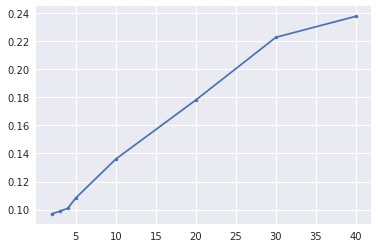

In [25]:
elbow_plot(decomp.fit_transform(X), MiniBatchKMeans, [2,3,4,5,10,20,30,40], **km_pars)

[ 0.03460531  0.05587697]


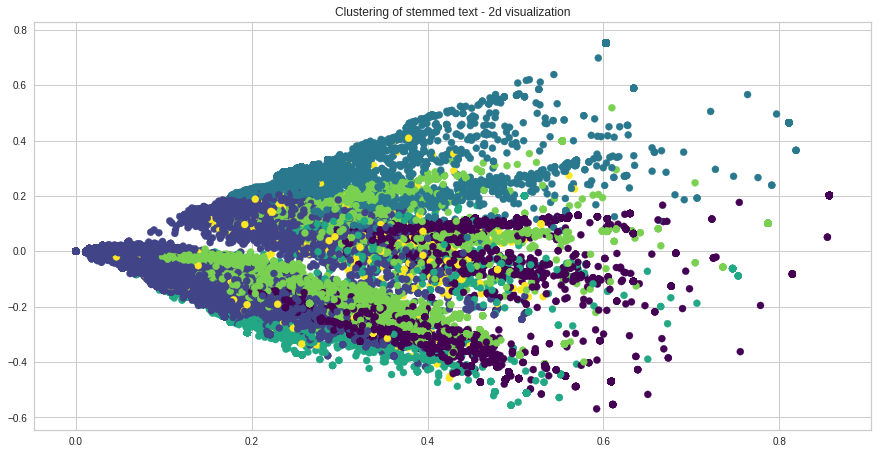

In [13]:
twod_plot(vocab, y_km, title='Clustering of stemmed text - 2d visualization', no_samples=None, savefig=False)

[ 0.03460473  0.05587429  0.03997301]


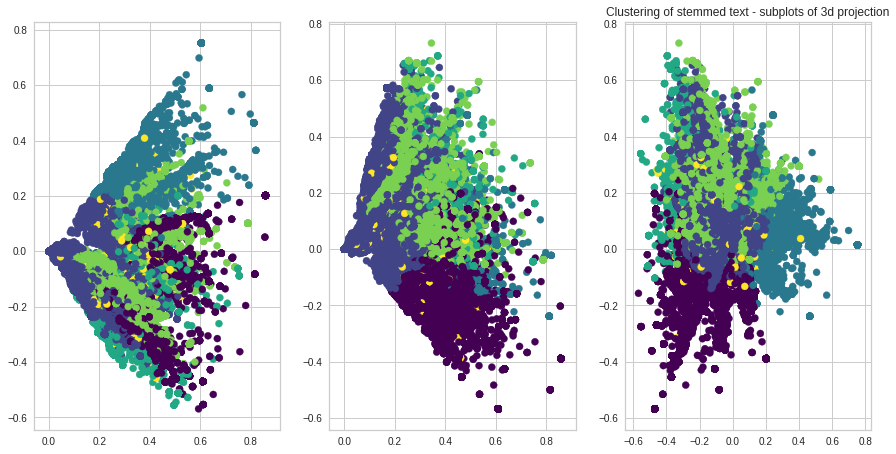

In [14]:
threed_subplots(vocab, y_km, title='Clustering of stemmed text - subplots of 3d projection', no_samples=None, savefig=False)

[ 0.03460564  0.05587629  0.0399727 ]


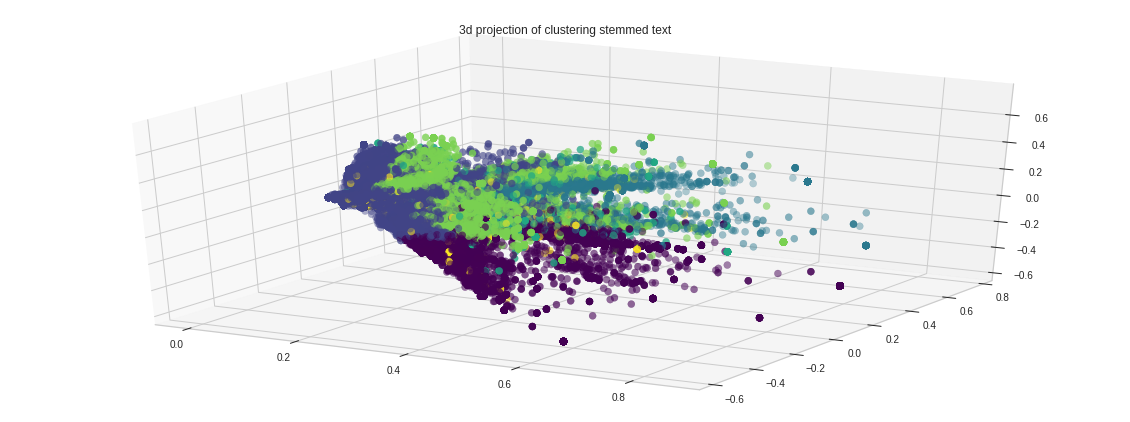

In [15]:
threed_plot(vocab, y_km, title='3d projection of clustering stemmed text', no_samples=None, savefig=False)

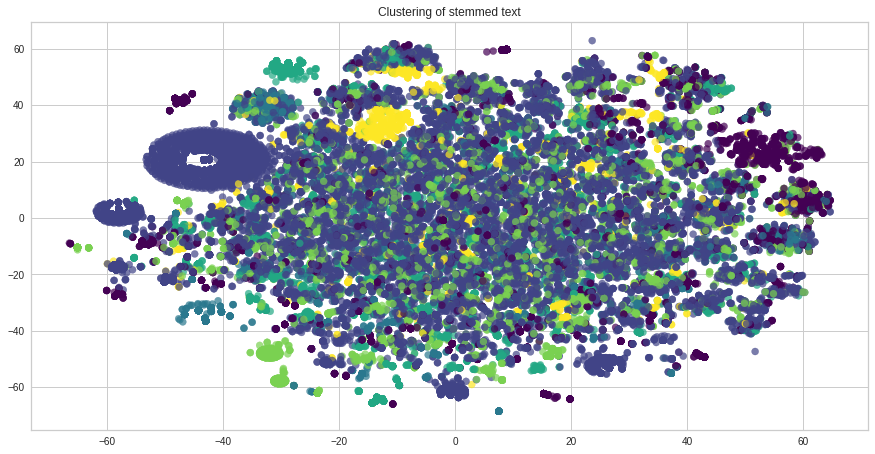

In [16]:
save_model_stemmed = False
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_stemmed:
    X_tsne = TSNE().fit_transform(vocab.toarray())
    filename = '../Models/'+date+'-tsne_stemmed.pkl'  
    with open(filename, 'wb') as file:  
        pickle.dump(X_tsne, file)
else:
    file = '../Models/2018_08_24_17_01-tsne_stemmed.pkl'
    with open(file, 'rb') as f:  
        tsne_model_stemmed = pickle.load(f)

tsne_plot(tsne_model_stemmed, no_samples=None, y=y_km, title='Clustering of stemmed text', savefig=False)

In [45]:
metric_params = {}

st_dbscan = DBSCAN(eps=0.0000001, 
                   min_samples=5, 
                   metric='jaccard', 
                   metric_params=None, 
                   algorithm='auto', 
                   leaf_size=5,
                   p=5,
                   n_jobs=-1)

X_db = vocab[:]
y_db = st_dbscan.fit_predict(X_db.toarray())

[ 0.03460408  0.05587601]


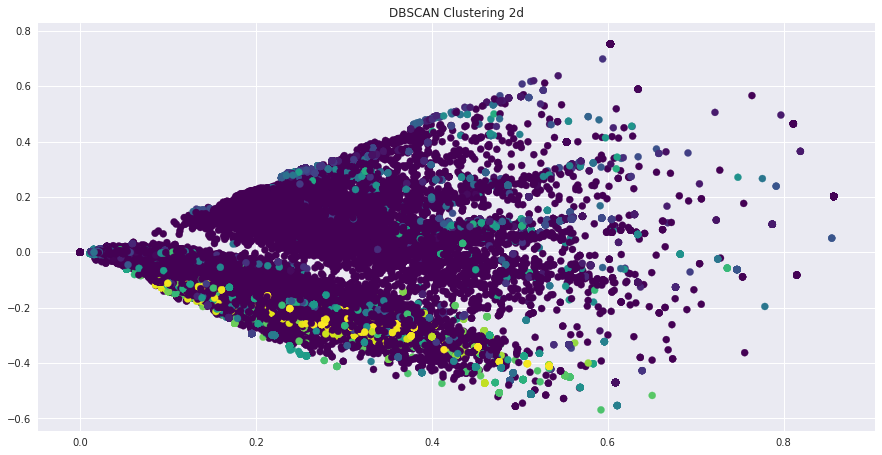

In [52]:
twod_plot(vocab, y_db, title='DBSCAN Clustering 2d', no_samples=None, savefig=False)

[ 0.03460504  0.05587487  0.03996569]


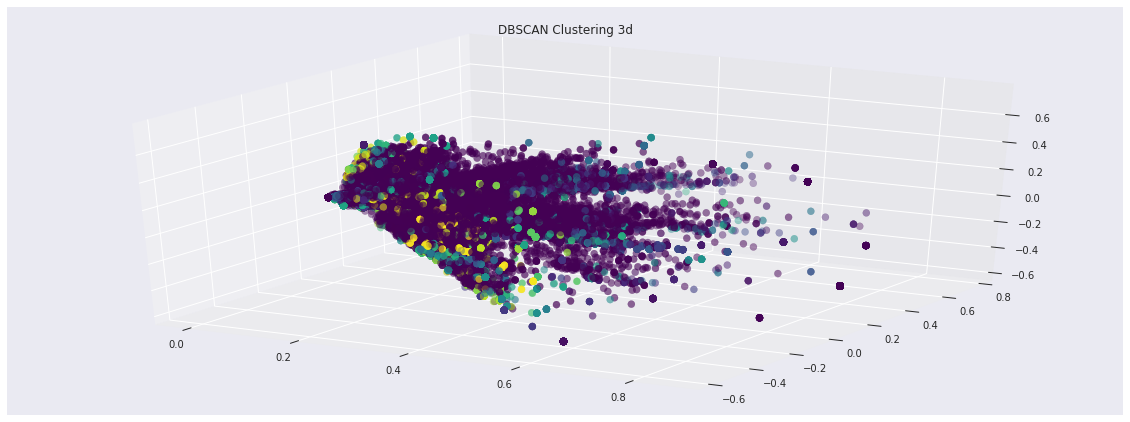

In [54]:
threed_plot(vocab, y_db, title='DBSCAN Clustering 3d', no_samples=None, savefig=False)

### 1.2 Cluster full feature vector: 
stemmed text, parties, tags, mentions

In [61]:
'''
In the following, I define various pipes. First for vectorization of the respective features, 
second for the clustering algorithm and 
last for dimensionality reduction for visualization.
'''

# count if party is mentioned in a tweet or not
# binarize to ensure that only the information whether party is mentioned or not is used, not how often it is mentioned
parties_pipe = Pipeline([('BOW', CountVectorizer(dtype = float)), 
                         ('onehot', Binarizer())])

# use hashing trick for tags and mentions for scalability
tags_pipe = Pipeline([('fhasher', FeatureHasher(n_features=1000, input_type='string'))])

# tfidf takes document frequency of a word into account - often mentioned words are weighed less than they would be using bow eg
# theoretically tfidf also normalizes the data, additional scaler can still be helpful especially with large datasets
text_pipe = Pipeline([('word_embedding', TfidfVectorizer(decode_error='strict',  
                                                    ngram_range=(1, 2),
                                                    stop_words=stopwords_de,
                                                    min_df=0.01,
                                                    dtype=float))])

# apply the above defined pipelines to the respective columns in the df
mapper = DataFrameMapper([('tags', tags_pipe), 
                          ('parties', parties_pipe),
                          ('mentions', tags_pipe),
                          ('stemmed', text_pipe)])

# fuse the vectorized features and apply MiniBatchKMeans (KMeans runs into memory problems)
pipe = Pipeline([('mapper', mapper),
                 ('clust', MiniBatchKMeans(n_clusters=6, 
                                                batch_size=5000,
                                                n_init = 1000, 
                                                init='k-means++', 
                                                max_iter=100))])

# fuse the vectorized features and apply dimensionality reduction (based on variation) for visualization
decomp3_pipe = Pipeline([('mapper', full_mapper),
                             ('decomp', TruncatedSVD(n_components=3))]) 
decomp2_pipe = Pipeline([('mapper', full_mapper),
                             ('decomp', TruncatedSVD(n_components=2))])

# fuse vectorized features and apply dimensionality reduction (based on how close data points are to one another) for visualization
tsne_pipe = Pipeline([('mapper', full_mapper),
                      ('tsne', TSNE())])

In [64]:
Xfull = mapper.fit_transform(df_part)

In [66]:
full_kmeans = MiniBatchKMeans(n_clusters=6, 
                            **km_pars)

decomp = TruncatedSVD(n_components=50)
yfull_km = full_kmeans.fit_predict(Xfull)

[ 0.50726867  0.16172763]


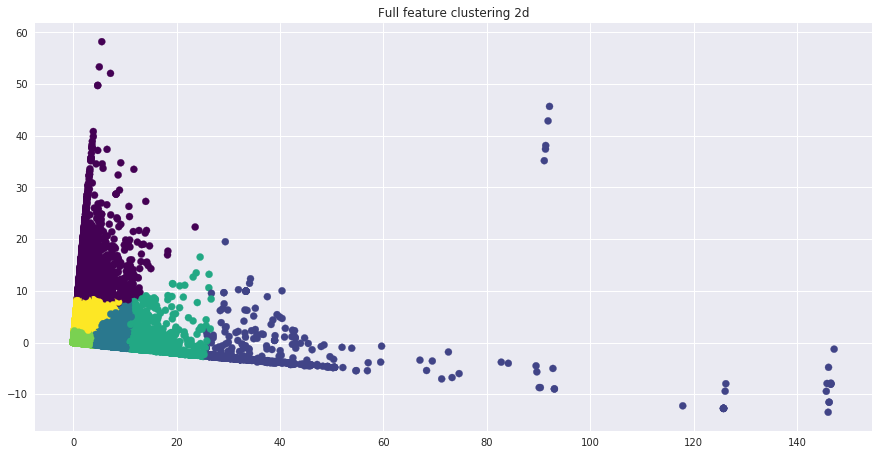

In [67]:
twod_plot(Xfull, yfull_km, title='Full feature clustering 2d', no_samples=None, savefig=False)twod_plot(Xfull, yfull_km, title='Full feature clustering 2d', no_samples=None, savefig=False)

[ 0.50726867  0.16172763  0.02515731]


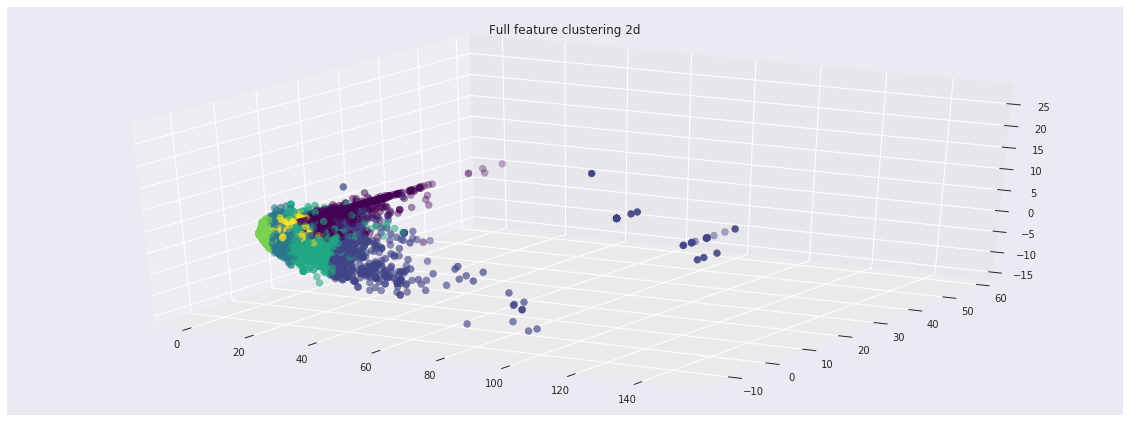

In [68]:
threed_plot(Xfull, yfull_km, title='Full feature clustering 2d', no_samples=None, savefig=False)

[ 0.50726867  0.16172763  0.02515696]


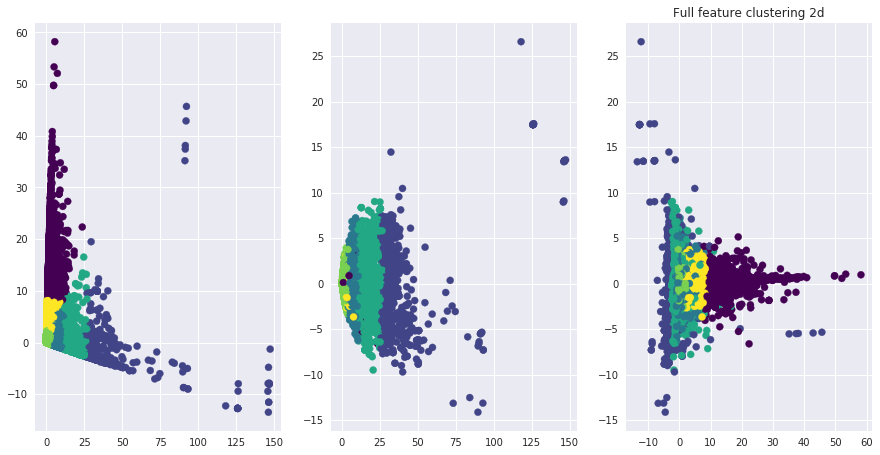

In [69]:
threed_subplots(Xfull, yfull_km, title='Full feature clustering 2d', no_samples=None, savefig=False)

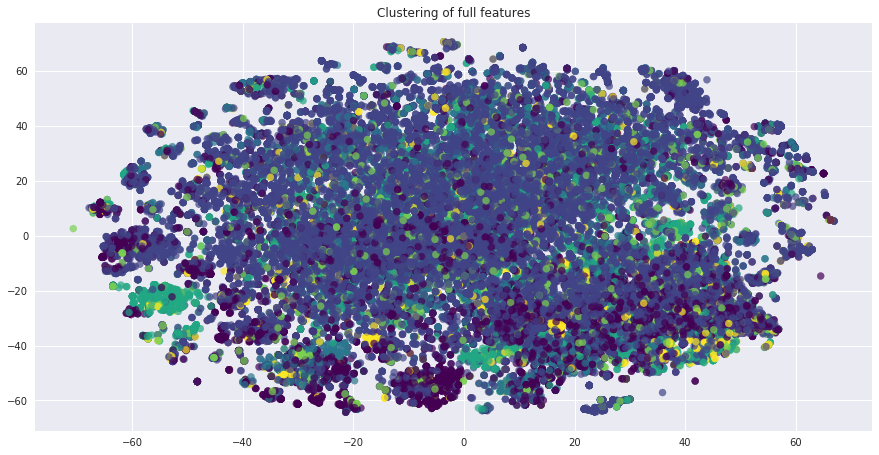

In [75]:
save_model_stemmed = False
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_stemmed:
    Xfull_tsne = TSNE().fit_transform(Xfull)
    filename = '../Models/'+date+'-tsnefull.pkl'
    print(filename)
    with open(filename, 'wb') as file:  
        pickle.dump(Xfull_tsne, file)
else:
    file = '../Models/2018_08_24_18_39-tsnefull.pkl'
    with open(file, 'rb') as f:  
        Xfull_tsne = pickle.load(f)

tsne_plot(Xfull_tsne, no_samples=None, y=y_km, title='Clustering of full features', savefig=False)

In [74]:
print(filename)

../Models/2018_08_24_18_39-tsnefull.pkl


# Old Clustering

1. partial dataframe already created
2. tags, parties, mentions are lists in a df cell - make them non-lists by joining them in the cell using commas
3. create pipelines to prepare features individually (could be done without pipelines here, but this way feature preparation is more easily expandable and I find it more readable)
4. map the individual pipelines to the respective features (columns in a dataframe) and unite the features
5. create full pipelines: clustering, elbow visualization, and decomposition for final visualization
6. use elbow visualizer to define number of clusters
7. fit-predict clusters using MiniBatchKmeans
8. reduce dimensionality to 3 dimensions (with 2 dimensions clusters overlap very strongly)
9. visualize

### Clustering: clean text column contains parties

In [5]:
'''
In the following, I define various pipes. First for vectorization of the respective features, 
second for the clustering algorithm and 
last for dimensionality reduction for visualization.
'''

# count if party is mentioned in a tweet or not
# binarize to ensure that only the information whether party is mentioned or not is used, not how often it is mentioned
parties_pipe = Pipeline([('BOW', CountVectorizer(dtype = float)), 
                         ('onehot', Binarizer())])

# use hashing trick for tags and mentions for scalability
tags_pipe = Pipeline([('fhasher', FeatureHasher(n_features=1000, input_type='string'))])

# tfidf takes document frequency of a word into account - often mentioned words are weighed less than they would be using bow eg
# theoretically tfidf also normalizes the data, additional scaler can still be helpful especially with large datasets
text_pipe = Pipeline([('word_embedding', TfidfVectorizer(decode_error='strict',                                                           ngram_range=(1, 2),
                                                          stop_words=stopwords_de,
                                                          min_df=0.01,
                                                          dtype=float))])
#                         ('scaler', StandardScaler(with_mean=False))]) 

# apply the above defined pipelines to the respective columns in the df
full_mapper = DataFrameMapper([('tags', tags_pipe), 
                               ('parties', parties_pipe),
                               ('mentions', tags_pipe),
                               ('clean_text', text_pipe)
                              ])

# fuse the vectorized features and apply MiniBatchKMeans (KMeans runs into memory problems)
full_pipe = Pipeline([('mapper', full_mapper),
                      ('clust', MiniBatchKMeans(n_clusters=6, 
                                                batch_size=5000,
                                                n_init = 1000, 
                                                init='k-means++', 
                                                max_iter=100))])

# fuse the vectorized features and apply Elbow visualizer to get an approximation over how many clusters are in the data
full_Kelbow_pipe = Pipeline([('mapper', full_mapper),
                             ('viz', KElbowVisualizer(MiniBatchKMeans(), 
                                                    metric='silhouette', 
                                                    k=[2, 10]))])

# fuse the vectorized features and apply dimensionality reduction (based on variation) for visualization
full_decomp_pipe = Pipeline([('mapper', full_mapper),
                             ('decomp', TruncatedSVD(n_components=3))])

# fuse vectorized features and apply dimensionality reduction (based on how close data points are to one another) for visualization
full_tsne_pipe = Pipeline([('mapper', full_mapper),
                           ('tsne', TSNE())])

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('tags', Pipeline(memory=None,
     steps=[('fhasher', FeatureHasher(alternate_sign=True, dtype=<class 'numpy.float64'>,
       input_type='string', n_features=1000, non_negative=False))])), ('parties', Pipeline(memory=...ots.AxesSubplot object at 0x7f5904f14470>,
         k=None, metric=None, model=None, timings=True))])

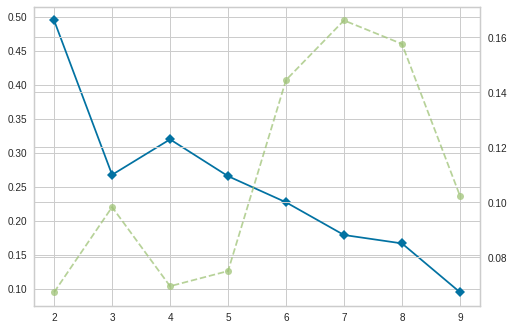

In [35]:
full_Kelbow_pipe.fit(df_part[1000:3000]) # should choose random rows!

In [13]:
y_km_full = full_pipe.fit_predict(df_part)

KeyboardInterrupt: 

In [13]:
full_features_decomp = full_decomp_pipe.fit_transform(df_part)

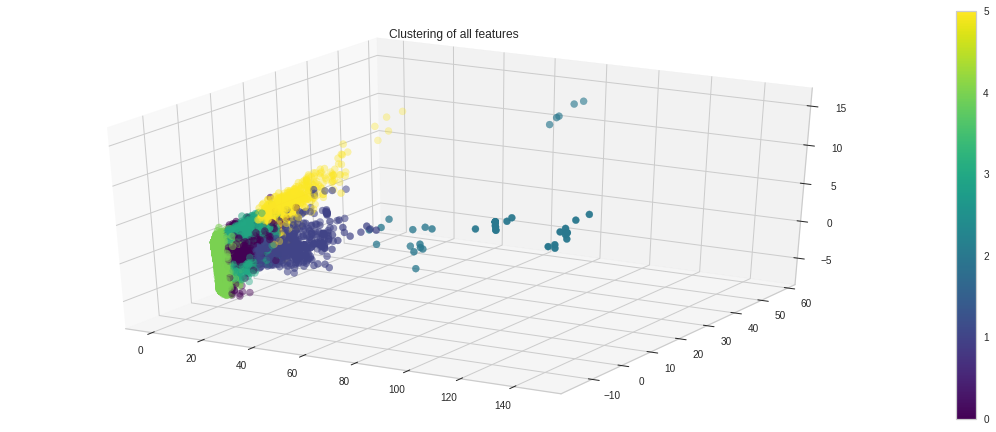

In [14]:
full_fig = plt.figure(figsize=(20, 7.5))
full_ax = full_fig.add_subplot(111, projection='3d')

full_scatter = full_ax.scatter(full_features_decomp[:, 0], full_features_decomp[:, 1], full_features_decomp[:, 2], c=y_km_full, s=50, cmap='viridis')
plt.title('Clustering of all features')
plt.colorbar(full_scatter, ticks=np.arange(6))
plt.show()

In [15]:
full_fig.savefig('../Figures/CLST_all_features.png', bbox_inches='tight')

In [150]:
full_X_tsne = full_tsne_pipe.fit_transform(df_part)

In [432]:
save_model_full = False
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_full:
    full_filename = '../Models/'+date+'-tsne_full.pkl'  
    with open(full_filename, 'wb') as file:  
        pickle.dump(full_X_tsne, file)
else:
    full_file = '../Models/2018_08_23_17_12-tsne_full.pkl'
    with open(full_file, 'rb') as file:  
        full_tsne_model = pickle.load(file)

In [433]:
fig2_full = plt.figure(figsize=(15, 7.5))
plt.scatter(full_tsne_model[:, 0], full_tsne_model[:, 1], c=y_km_full, s=50, cmap='viridis', alpha=0.7)
plt.title('Clustering of all features')
plt.show()

NameError: name 'y_km_full' is not defined

# Clustering: parties not in clean text

In [16]:
'''
Definition of pipelines as above. Feature vectorization (tags_pipe etc.) is as defined in the previous section.
Major difference to previous clustering: parties are no longer in the tweet texts.
'''

clean_mapper = DataFrameMapper([('tags', tags_pipe),
                               ('parties', parties_pipe),
                               ('mentions', tags_pipe),
                               ('no_parties', text_pipe)])

clean_pipe = Pipeline([('mapper', clean_mapper),
                       ('clust', MiniBatchKMeans(n_clusters=3, 
                                                 batch_size=5000,
                                                 n_init = 1000, 
                                                 init='k-means++', 
                                                 max_iter=100))])

clean_kelbow_pipe = Pipeline([('mapper', full_mapper),
                        ('viz', KElbowVisualizer(MiniBatchKMeans(), 
                                                 metric='silhouette', 
                                                 k=[2, 19]))])

clean_decomp_pipe = Pipeline([('mapper', clean_mapper),
                              ('decomp', TruncatedSVD(n_components=3))])

clean_tsne_pipe = Pipeline([('mapper', clean_mapper),
                              ('tsne', TSNE())])

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('tags', Pipeline(memory=None,
     steps=[('fhasher', FeatureHasher(alternate_sign=True, dtype=<class 'numpy.float64'>,
       input_type='string', n_features=1000, non_negative=False))])), ('parties', Pipeline(memory=...ots.AxesSubplot object at 0x7f9364a81b38>,
         k=None, metric=None, model=None, timings=True))])

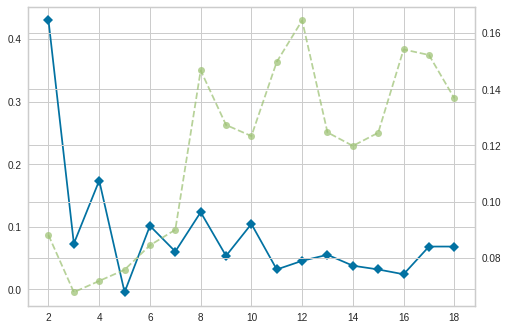

In [17]:
clean_kelbow_pipe.fit(df_part[1000:3000])

In [18]:
y_km_clean = clean_pipe.fit_predict(df_part)

In [19]:
clean_features_decomp = clean_decomp_pipe.fit_transform(df_part)

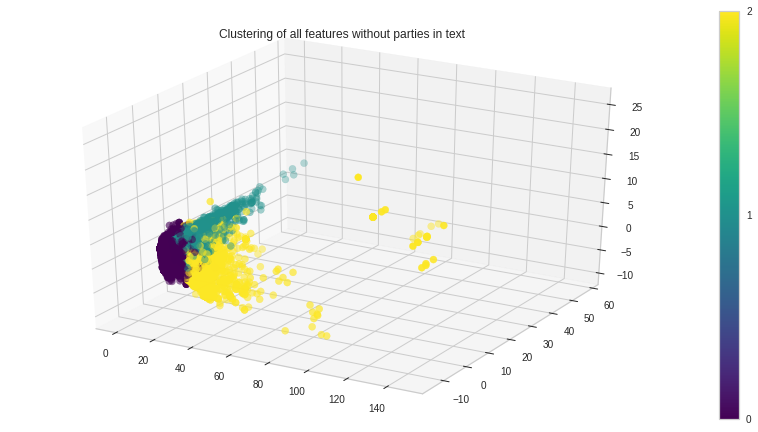

In [20]:
clean_fig = plt.figure(figsize=(15, 7.5))
clean_ax = clean_fig.add_subplot(111, projection='3d')

clean_scatter = clean_ax.scatter(clean_features_decomp[:, 0], clean_features_decomp[:, 1], clean_features_decomp[:, 2], c=y_km_clean, s=50, cmap='viridis')
plt.title('Clustering of all features without parties in text')
plt.colorbar(clean_scatter, ticks=np.arange(3))
plt.show()

In [21]:
clean_fig.savefig('../Figures/CLST_allf_noparties.png', bbox_inches='tight')

In [145]:
clean_X_tsne = clean_tsne_pipe.fit_transform(df_part)

save_model_clean = False
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_clean:
    clean_filename = '../Models/'+date+'-tsne_clean.pkl'  
    with open(clean_filename, 'wb') as file:  
        pickle.dump(clean_X_tsne, file)
else:
    clean_file = '../Models/2018_08_23_17_09-tsne_clean.pkl'
    with open(clean_file, 'rb') as file:  
        clean_tsne_model = pickle.load(file)

fig2_clean = plt.figure(figsize=(15, 7.5))
plt.scatter(clean_X_tsne[:, 0], clean_X_tsne[:, 1], c=y_km_clean, s=50, cmap='viridis', alpha=0.7)
plt.title('Clustering of all features without parties in text')
plt.show()

### Clustering: full, uncleaned text


In [22]:
svd = TruncatedSVD(n_components=3)

In [26]:
qd_X = text_pipe.fit_transform(all_data.loc[:, 'full_text'].tolist())

In [27]:
print(qd_X.shape)

(46267, 80)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f93655bf198>,
         k=None, metric=None, model=None, timings=True)

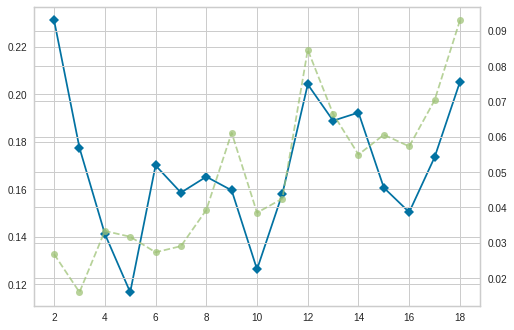

In [28]:
"""
Use the elbow visualizer to find the optimal number of clusters for KMeans
Use MiniBatchKMeans to circumvent memory errors
"""

visualizer = KElbowVisualizer(MiniBatchKMeans(), metric='silhouette', k=[2, 19])
visualizer.fit(qd_X[1000:3000])

In [29]:
""" 
Define MiniBatchKMeans with the optimal number of clusters derived from the elbow visualizer
Use MiniBatchKMeans to circumvent memory errors
"""

qd_kmeans = MiniBatchKMeans(n_clusters=4, 
                            batch_size = 5000,
                            n_init = 1000, 
                            init='k-means++',
                            max_iter=50)

In [30]:
qd_y = qd_kmeans.fit_predict(qd_X)

In [31]:
qd_X_decomp = svd.fit_transform(qd_X)

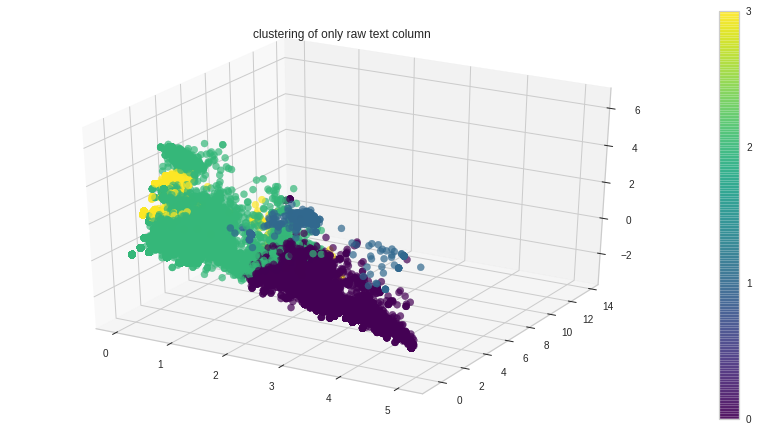

In [32]:
""" Plot features, cluster and cluster centers"""
xs = qd_X_decomp[:, 0]
ys = qd_X_decomp[:, 1]
zs = qd_X_decomp[:, 2]

qd_fig = plt.figure(figsize=(15, 7.5))
qd_ax = qd_fig.add_subplot(111, projection='3d')
qd_scatter = qd_ax.scatter(xs=xs, ys=ys, zs=zs, c=qd_y, s=50, cmap='viridis', alpha=0.7)
plt.title('clustering of only raw text column')
plt.colorbar(qd_scatter, ticks=np.arange(5))
plt.show()

In [33]:
qd_fig.savefig('../Figures/CLST_qd_rawtext.png', bbox_inches='tight')

In [134]:
qd_tsne = TSNE()

In [136]:
qd_X_tsne = qd_tsne.fit_transform(qd_X.toarray())

In [268]:
save_model_qd = True
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_qd:
    qd_filename = '../Models/'+date+'-tsne_qd.pkl'  
    with open(qd_filename, 'wb') as file:  
        pickle.dump(qd_X_tsne, file)
else:
    qd_file = '../Models/2018_08_23_17_01-tsne_qd.pkl'
    with open(qd_file, 'rb') as file:  
        qd_tsne_model = pickle.load(file)

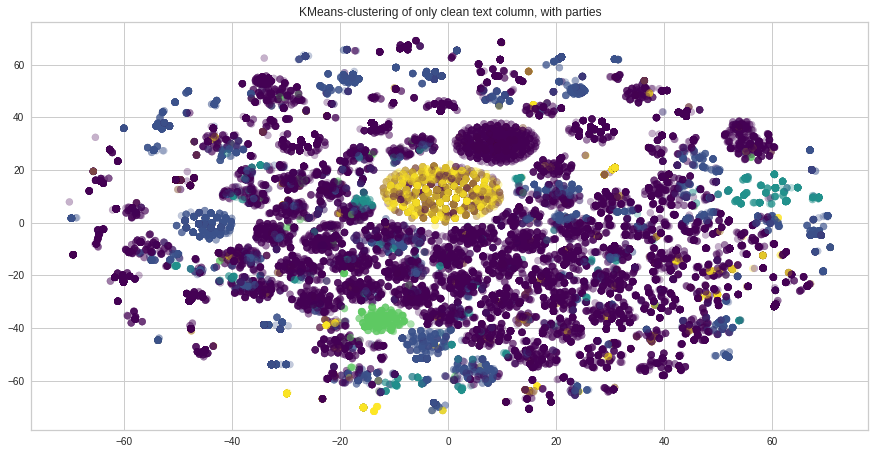

In [289]:
fig2_qd = plt.figure(figsize=(15, 7.5))
plt.scatter(qd_tsne_model[:, 0], qd_tsne_model[:, 1], c=y_km_ct, s=50, cmap='viridis', alpha=0.3)
plt.title('KMeans-clustering of only clean text column, with parties')
plt.show()

### Clustering: only clean text, with parties

In [12]:
type(X_ct)

scipy.sparse.csr.csr_matrix

In [ ]:
X2_ct = text_pipe.fit_transform(clean_text)

In [17]:
foo = list(X2_ct.steps[0][1].vocabulary_.keys())

In [ ]:
sorted(foo)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2682cbf98>,
         k=None, metric=None, model=None, timings=True)

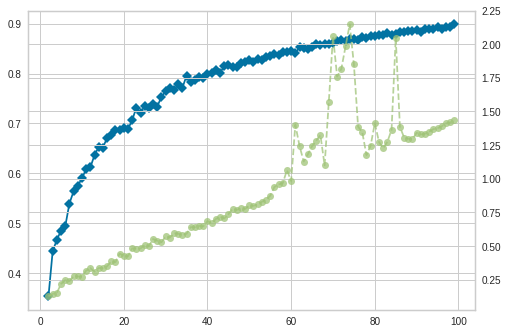

In [78]:
visualizer_ct = KElbowVisualizer(KMeans(), metric='silhouette', k=[2, 100]) # silhouette coefficient is used, when the ground truth about the dataset is unknown
visualizer_ct.fit(X2_ct)

In [159]:
X_ct.shape

(46267, 67)

In [305]:
ct_gmm = GaussianMixture(n_components=50, covariance_type='full', max_iter=500, n_init=5, init_params='random', verbose=True, verbose_interval=50)

In [201]:
ct_aggc = AgglomerativeClustering(n_clusters=50)

In [306]:
fit_gmm_ct = ct_gmm.fit(X_ct.toarray())

Initialization 0
  Iteration 0
Initialization converged: True
Initialization 1
  Iteration 0
Initialization converged: True
Initialization 2
  Iteration 0
Initialization converged: True
Initialization 3
  Iteration 0
Initialization converged: True
Initialization 4
  Iteration 0
Initialization converged: True


In [307]:
y_gmm_ct = fit_gmm_ct.predict(X_ct.toarray())

In [205]:
y_aggc_ct = ct_aggc.fit_predict(X_ct[:20000].toarray())

In [68]:
fig_ct.savefig('../Figures/CLST_text_ct.png', bbox_inches='tight')

In [108]:
ct_tsne = TSNE()

In [109]:
X_ct_tsne = ct_tsne.fit_transform(X_ct.toarray())

KeyboardInterrupt: 

In [88]:
save_model_ct = False
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_ct:
    ct_filename = '../Models/'+date+'-tsne_ct.pkl'  
    with open(ct_filename, 'wb') as file:  
        pickle.dump(X_ct_tsne, file)
else:
    ct_file = '../Models/2018_08_23_17_05-tsne_ct.pkl'
    with open(ct_file, 'rb') as file:  
        ct_tsne_model = pickle.load(file)

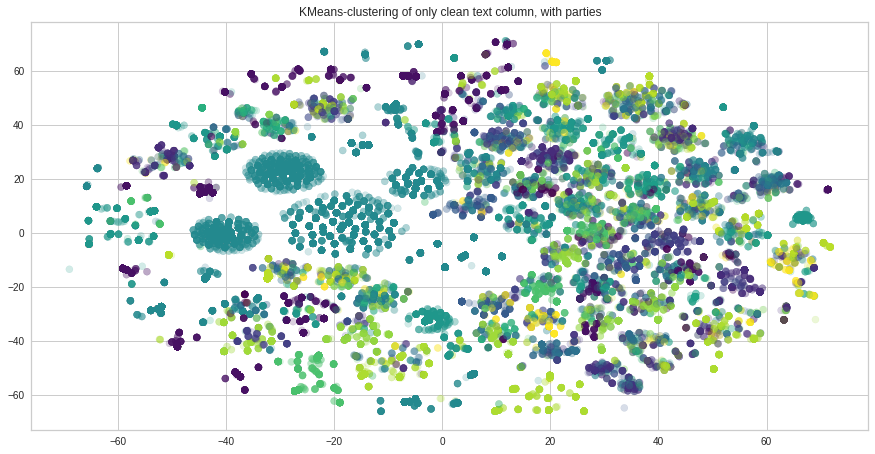

In [308]:
fig_gmm_ct = plt.figure(figsize=(15, 7.5))
plt.scatter(ct_tsne_model[:, 0], ct_tsne_model[:, 1], c=y_gmm_ct, s=50, cmap='viridis', alpha=0.2)
plt.title('KMeans-clustering of only clean text column, with parties')
plt.show()

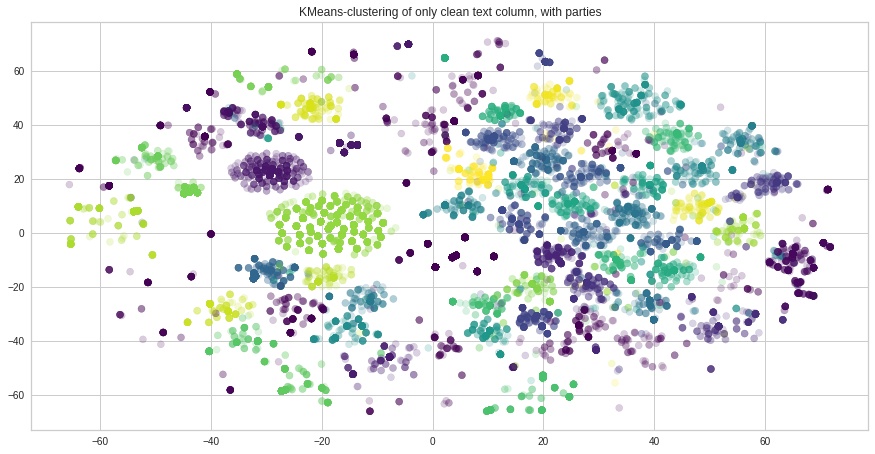

In [302]:
fig_aggc_ct = plt.figure(figsize=(15, 7.5))
plt.scatter(ct_tsne_model[:20000, 0], ct_tsne_model[:20000, 1], c=y_aggc_ct, s=50, cmap='viridis', alpha=0.2)
plt.title('KMeans-clustering of only clean text column, with parties')
plt.show()

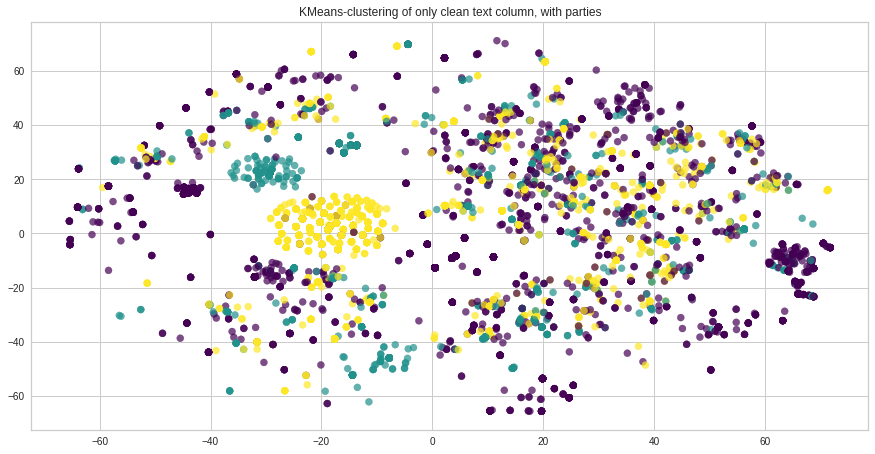

In [91]:
fig_km_ct = plt.figure(figsize=(15, 7.5))
plt.scatter(ct_tsne_model[:6000, 0], ct_tsne_model[:6000, 1], c=y_km_ct, s=50, cmap='viridis', alpha=0.7)
plt.title('KMeans-clustering of only clean text column, with parties')
plt.show()

In [90]:
fig2_ct.savefig('../Figures/CLST_txt_ct_tsne.png', bbox_inches='tight')

### Clustering: only clean text, with parties

In [46]:
np_text = df_part.loc[:, 'no_parties']

In [47]:
X_np = text_pipe.fit_transform(np_text)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f935db16a20>,
         k=None, metric=None, model=None, timings=True)

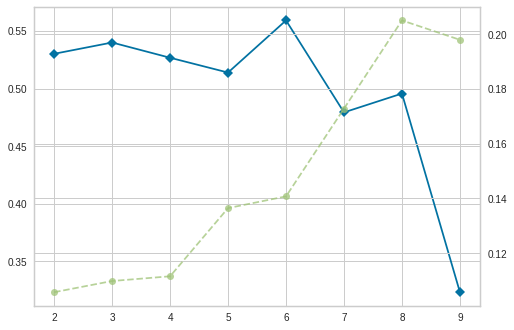

In [69]:
visualizer_np = KElbowVisualizer(KMeans(), metric='silhouette', k=[2, 10])
visualizer_np.fit(X_np[1000:3000])

In [131]:
np_kmeans = MiniBatchKMeans(n_clusters=80, 
                            batch_size = 1000,
                            n_init = 100, 
                            init='k-means++',
                            max_iter=200)

In [132]:
y_km_np = np_kmeans.fit_predict(X_np)

In [72]:
X_np_decomp = svd.fit_transform(X_np)

In [73]:
np_centers = np_kmeans.cluster_centers_

In [74]:
np_centers_decomp = svd.fit_transform(np_centers)

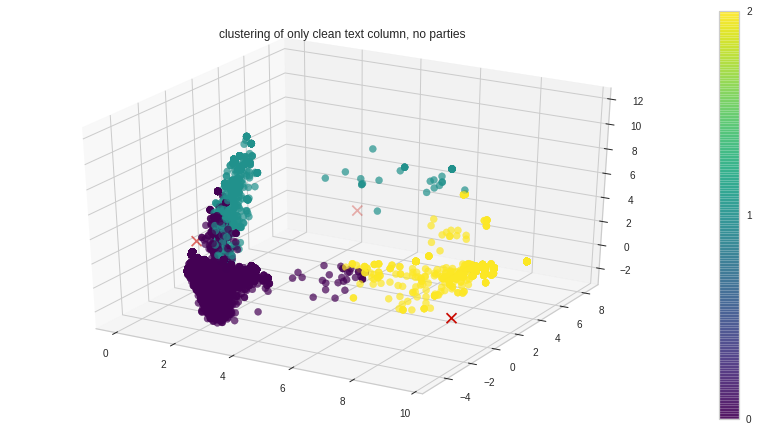

In [75]:
""" Plot features, cluster and cluster centers"""
xs = X_np_decomp[:, 0]
ys = X_np_decomp[:, 1]
zs = X_np_decomp[:, 2]

fig_np = plt.figure(figsize=(15, 7.5))
ax_np = fig_np.add_subplot(111, projection='3d')
scatter = ax_np.scatter(xs=xs, ys=ys, zs=zs, c=y_km_np, s=50, cmap='viridis', alpha=0.7)
scatter2 = ax_np.scatter(xs=np_centers_decomp[:,0], ys=np_centers_decomp[:,1], zs=np_centers_decomp[:,2], s=100, marker='x', c='r')
plt.title('clustering of only clean text column, no parties')
plt.colorbar(scatter, ticks=np.arange(3))
plt.show()

In [76]:
fig_np.savefig('../Figures/CLST_text_np.png', bbox_inches='tight')

In [123]:
np_tsne = TSNE()

In [124]:
X_np_tsne = np_tsne.fit_transform(X_ct.toarray())

In [278]:
save_model_np = False
date = dt.datetime.strftime(dt.datetime.now(), '%Y_%m_%d_%H_%M')

if save_model_np:
    np_filename = '../Models/'+date+'-tsne_np.pkl'  
    with open(np_filename, 'wb') as file:  
        pickle.dump(X_np_tsne, file)
else:
    np_file = '../Models/2018_08_23_17_07-tsne_np.pkl'
    with open(np_file, 'rb') as file:  
        np_tsne_model = pickle.load(file)

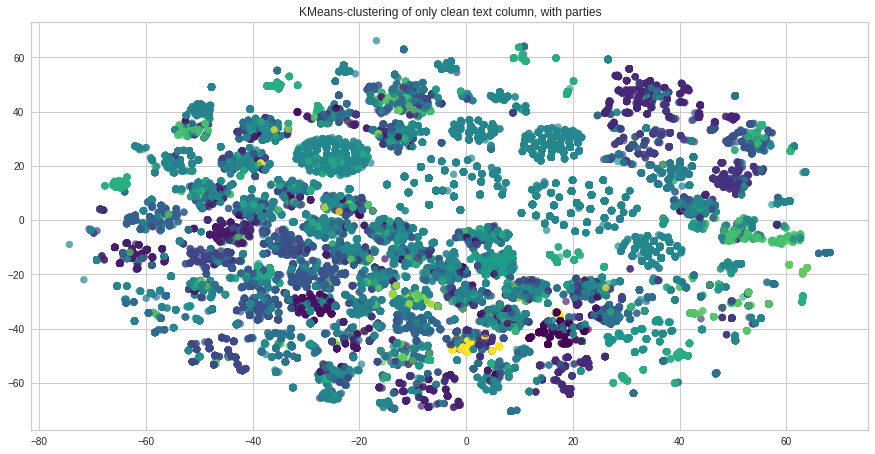

In [133]:
fig2_np = plt.figure(figsize=(15, 7.5))
plt.scatter(X_np_tsne[:, 0], X_np_tsne[:, 1], c=y_km_np, s=50, cmap='viridis', alpha=0.7)
plt.title('KMeans-clustering of only clean text column, without parties')
plt.show()